In [2]:
import sys, os
import matplotlib.pyplot as plt
sys.path.append('../')
from sklearn.metrics import mean_squared_error
import re
import numpy as np

In [3]:
from core.models import rUNet
from core.utils.inference import inference_phase_rUNet_plot_notebook, inference_phase_rUNet
from core.utils.data import define_dataset, select_dist

In [4]:
from functools import partial

In [5]:
import torch

In [6]:
%matplotlib inline

In [7]:
regex = re.compile(r'\d+')

In [8]:
saved_models = '/storage/yw18581/src/leaf_reco/saved_models/trained_6positions_multi_loss/'

In [9]:
root_path = partial(os.path.join, saved_models)

In [10]:
data_folder = ('/storage/yw18581/data/dataset/')

In [11]:
model_names = os.listdir(saved_models)

In [12]:
def get_fnames(coeff, prefix='Trained'):
    idx_coef = 6 if prefix=='Trained' else 4
    idx_epoch = 5 if prefix =='Trained' else 3
    f_list = []
    epochs = []
    for fname in model_names:
        if fname.startswith(prefix):
            if regex.findall(fname.split("_")[idx_coef])[1]==str(coeff):
                epoch = int(regex.findall(fname.split("_")[idx_epoch])[0]) 
                epochs.append(epoch)
                if int(regex.findall(fname.split("_")[idx_epoch])[0])==epoch:
                    f_list.append(fname)
    
    return np.array(f_list)[np.argsort(epochs)], np.sort(epochs)

In [13]:
training_dist = [2,4,10,20,25,35]
unseen_dist = [1,3,15,30]

In [14]:
selected_unseen = select_dist(unseen_dist, data_folder)

In [15]:
data_loaders_unseen, data_length_unseen = define_dataset(data_folder, batch_size=16,
                                                    include_list=selected_unseen,
                                                     alldata=True)

In [16]:
data_length_unseen

3532

In [17]:
selected_test = select_dist(training_dist, data_folder)

In [18]:
data_loaders_test, data_length_test = define_dataset(data_folder, batch_size=16,
                                                    include_list=selected_test,
                                                     alldata=False)

In [19]:
data_length_test

{'train': 3456, 'val': 864, 'test': 1080}

#### look at history

In [20]:
history = np.load(root_path('history_Trained_rUNet_pytorch_100epochs_0.4coef.pkl'),allow_pickle=True)

In [21]:
epochs = history['epochs']

In [22]:
val_loss = history['val']
val_dice = history['val_dice']
val_mse = history['val_mse']

train_loss = history['train']
train_dice = history['train_dice']
train_mse = history['train_mse']



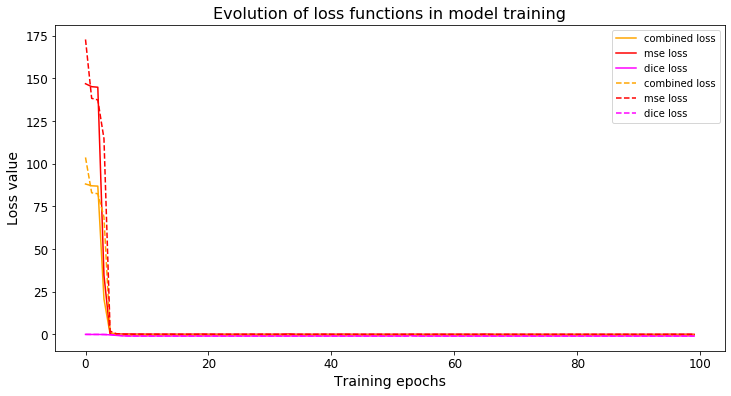

In [39]:
plt.figure(figsize=(12,6))
plt.plot(epochs, val_loss, c='orange', label='combined loss' )
plt.plot(epochs, val_mse, c='red', label='mse loss')
plt.plot(epochs, val_dice, c='magenta', label='dice loss')
plt.plot(epochs, train_loss, '--',c='orange', label='combined loss' )
plt.plot(epochs, train_mse, '--',c='red', label='mse loss')
plt.plot(epochs, train_dice, '--',c='magenta', label='dice loss')
plt.legend(loc='upper right')
plt.xlabel("Training epochs", size=14)
plt.ylabel("Loss value",size=14)
plt.xticks(range(0, 110, 20), size=12)
plt.yticks(range(0,180, 25), size=12)
plt.title("Evolution of loss functions in model training",size=16)
plt.savefig("loss_complete.png")
plt.show()


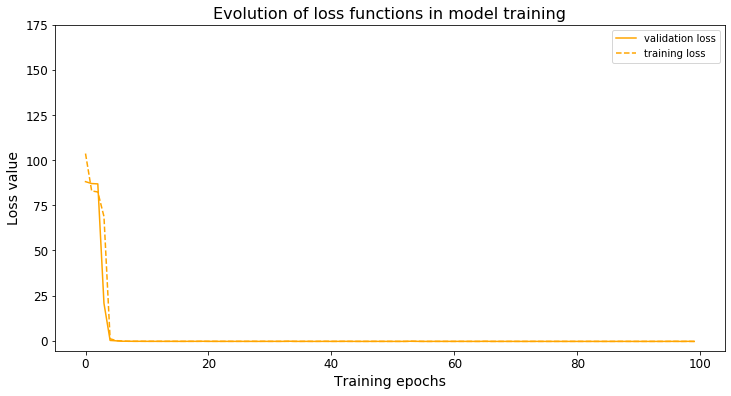

In [53]:
plt.figure(figsize=(12,6))
plt.plot(epochs, val_loss, c='orange', label='validation loss' )
#plt.plot(epochs, val_mse, c='red', label='mse loss')
#plt.plot(epochs, val_dice, c='magenta', label='dice loss')
plt.plot(epochs, train_loss, '--',c='orange', label='training loss' )
#plt.plot(epochs, train_mse, '--',c='red', label='mse loss')
#plt.plot(epochs, train_dice, '--',c='magenta', label='dice loss')
plt.legend(loc='upper right')
plt.xlabel("Training epochs", size=14)
plt.ylabel("Loss value",size=14)
plt.xticks(range(0, 110, 20), size=12)
plt.yticks(range(0,180, 25), size=12)
plt.title("Evolution of loss functions in model training",size=16)
plt.savefig("loss_combined.png")
plt.show()

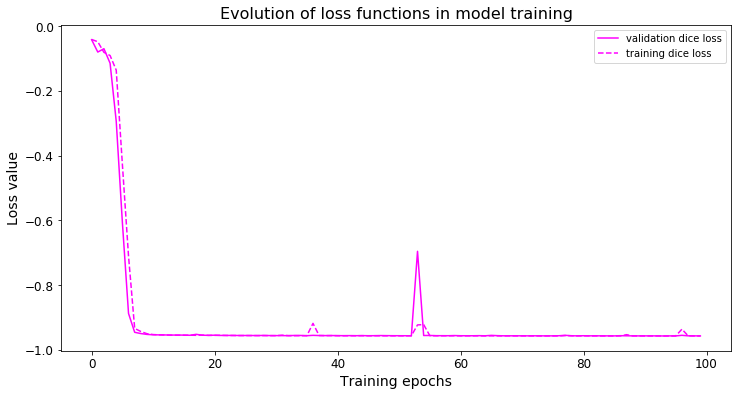

In [45]:
plt.figure(figsize=(12,6))
#plt.plot(epochs, val_loss, c='orange', label='combined loss' )
#plt.plot(epochs, val_mse, c='red', label='mse loss')
plt.plot(epochs, val_dice, c='magenta', label='validation dice loss')
plt.plot(epochs, train_dice, '--',c='magenta',label='training dice loss' )
plt.legend(loc='upper right')
plt.xlabel("Training epochs", size=14)
plt.ylabel("Loss value",size=14)
plt.xticks(range(0, 110, 20), size=12)
plt.yticks(np.arange(-1,0.2, 0.2), size=12)
plt.title("Evolution of loss functions in model training",size=16)
plt.savefig("dice_loss.png")
plt.show()





In [29]:
val_dice[-1]

-0.9574064722767582

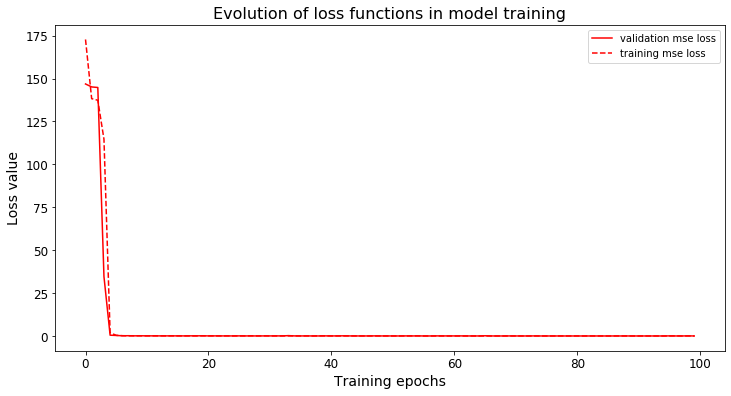

In [49]:
plt.figure(figsize=(12,6))
#plt.plot(epochs, val_loss, c='orange', label='combined loss' )
#plt.plot(epochs, val_mse, c='red', label='mse loss')
plt.plot(epochs, val_mse, c='red', label='validation mse loss')
plt.plot(epochs, train_mse, '--',c='red',label='training mse loss' )
plt.legend(loc='upper right')
plt.xlabel("Training epochs", size=14)
plt.ylabel("Loss value",size=14)
plt.xticks(range(0, 110, 20), size=12)
plt.yticks(np.arange(0,180, 25), size=12)
plt.title("Evolution of loss functions in model training",size=16)
plt.savefig("mse_loss.png")
plt.show()





In [55]:
val_mse[-1]

0.002885519203522967

In [33]:
def predict_dist(coeff, epoch,data_loaders, data_lengths, key, only_test=True):
    filelist, epochs = get_fnames(coeff)
    model_fname = filelist[int(np.argwhere(epochs==epoch)[0])]
    print(model_fname)
    
    torch.cuda.empty_cache()
    model = rUNet(out_size=1)
    checkpoint = torch.load(root_path(model_fname))['model_state_dict']
    model.load_state_dict(checkpoint)
    y_true, y_pred = inference_phase_rUNet(model, data_loaders, data_lengths, batch_size=16,
                                               notebook=True, test=only_test)
    np.savez_compressed(os.path.join(saved_models, '_'.join(['predicted',
                                                                 key,
                                                                 model_fname.split('_')[3],
                                                                 model_fname.split('_')[5],
                                                                 model_fname.split('_')[6]])
                                         + '.npz'), true=y_true, pred=y_pred)
        
    mse=mean_squared_error(y_true, y_pred)
    print(mse)
    return

In [34]:
predict_dist(5, 25,data_loaders_test, data_length_test,'testdata', only_test=True)

Trained_rUNet_pytorch_6positions_dataset_25epochs_0.5coeff_mask.pkl



0.03368989605145138


In [35]:
predict_dist(5, 25,data_loaders_unseen, data_length_unseen,'unseen', only_test=False)

Trained_rUNet_pytorch_6positions_dataset_25epochs_0.5coeff_mask.pkl



0.08376971006688459
